<a href="https://colab.research.google.com/github/nawa53/code-Hackathon/blob/main/ISIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ติดตั้งไลบรารีที่จำเป็น
!pip install pandas
!pip install numpy
!pip install requests


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [8]:
# Function to load images from a folder into a dictionary
def load_images_from_folder(folder):
    image_dict = {}
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust the extensions based on your image types
            img_path = os.path.join(folder, filename)
            image = Image.open(img_path)
            image_dict[filename] = image
    return image_dict

# Paths to the folders
part1_folder = '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1'
part2_folder ='/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2'

# Load images from both folders
images_part1 = load_images_from_folder(part1_folder)
images_part2 = load_images_from_folder(part2_folder)

# Merge the dictionaries
merged_images = {**images_part1, **images_part2}

# Check the number of images loaded
print(f"Total images loaded: {len(merged_images)}")

Total images loaded: 10015


In [9]:
# Load the CSV file (adjust the path to your CSV file)
df = pd.read_csv('/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv')

# Define the slin lesion type dictionary
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

# Create the 'path' column which is just the image_id (since we are working with a dictionary, not file paths)
df['path'] = df['image_id'].apply(lambda x: f"{x}.jpg" if f"{x}.jpg" in merged_images else None)

# Filter out rows where the image is missing from the merged dictionary
df = df[df['path'].notnull()]

# Map the lesion type to the short name and store it in the 'cell_type' column
df['cell_type'] = df['dx'].map(lesion_type_dict)

# Create a categorical column 'cell_type_idx' by converting 'lesion_type' to categorical codes
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

# Check the dataframe
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg,Benign keratosis-like lesions,2


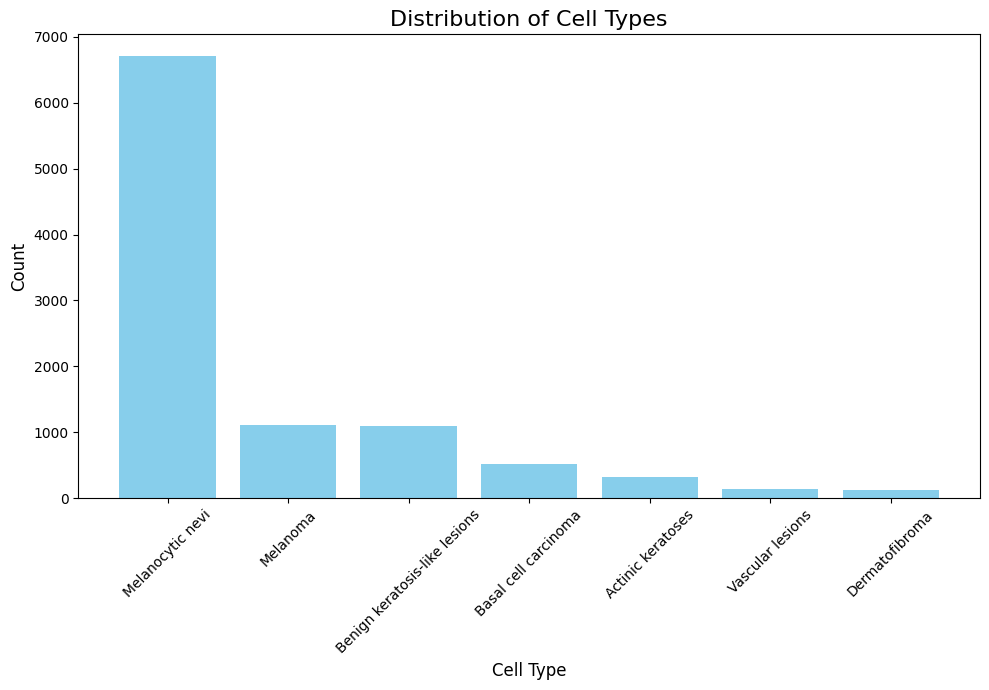

In [10]:
# Count the number of occurrences for each cell type
cell_type_counts = df['cell_type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 7))
plt.bar(cell_type_counts.index, cell_type_counts.values, color='skyblue')

# Add title and labels
plt.title('Distribution of Cell Types', fontsize=16)
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate the x-labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
df['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,6705
5,1113
2,1099
1,514
0,327
6,142
3,115


In [30]:
# Function to resize an image to the specified size (128x128)
def resize_image(image, size=(128, 128)):
    try:
        image = image.resize(size)
        return image
    except Exception as e:
        print(f"Error resizing image: {e}")
        return None

# Assuming df['path'] contains the image_id with '.jpg' extension as key in the merged_images dictionary
df['image'] = df['path'].apply(lambda x: resize_image(merged_images.get(x)))

# Check how many images were successfully loaded and resized
print(f"Images successfully resized and loaded: {df['image'].notnull().sum()} out of {len(df)}")

Images successfully resized and loaded: 10015 out of 10015


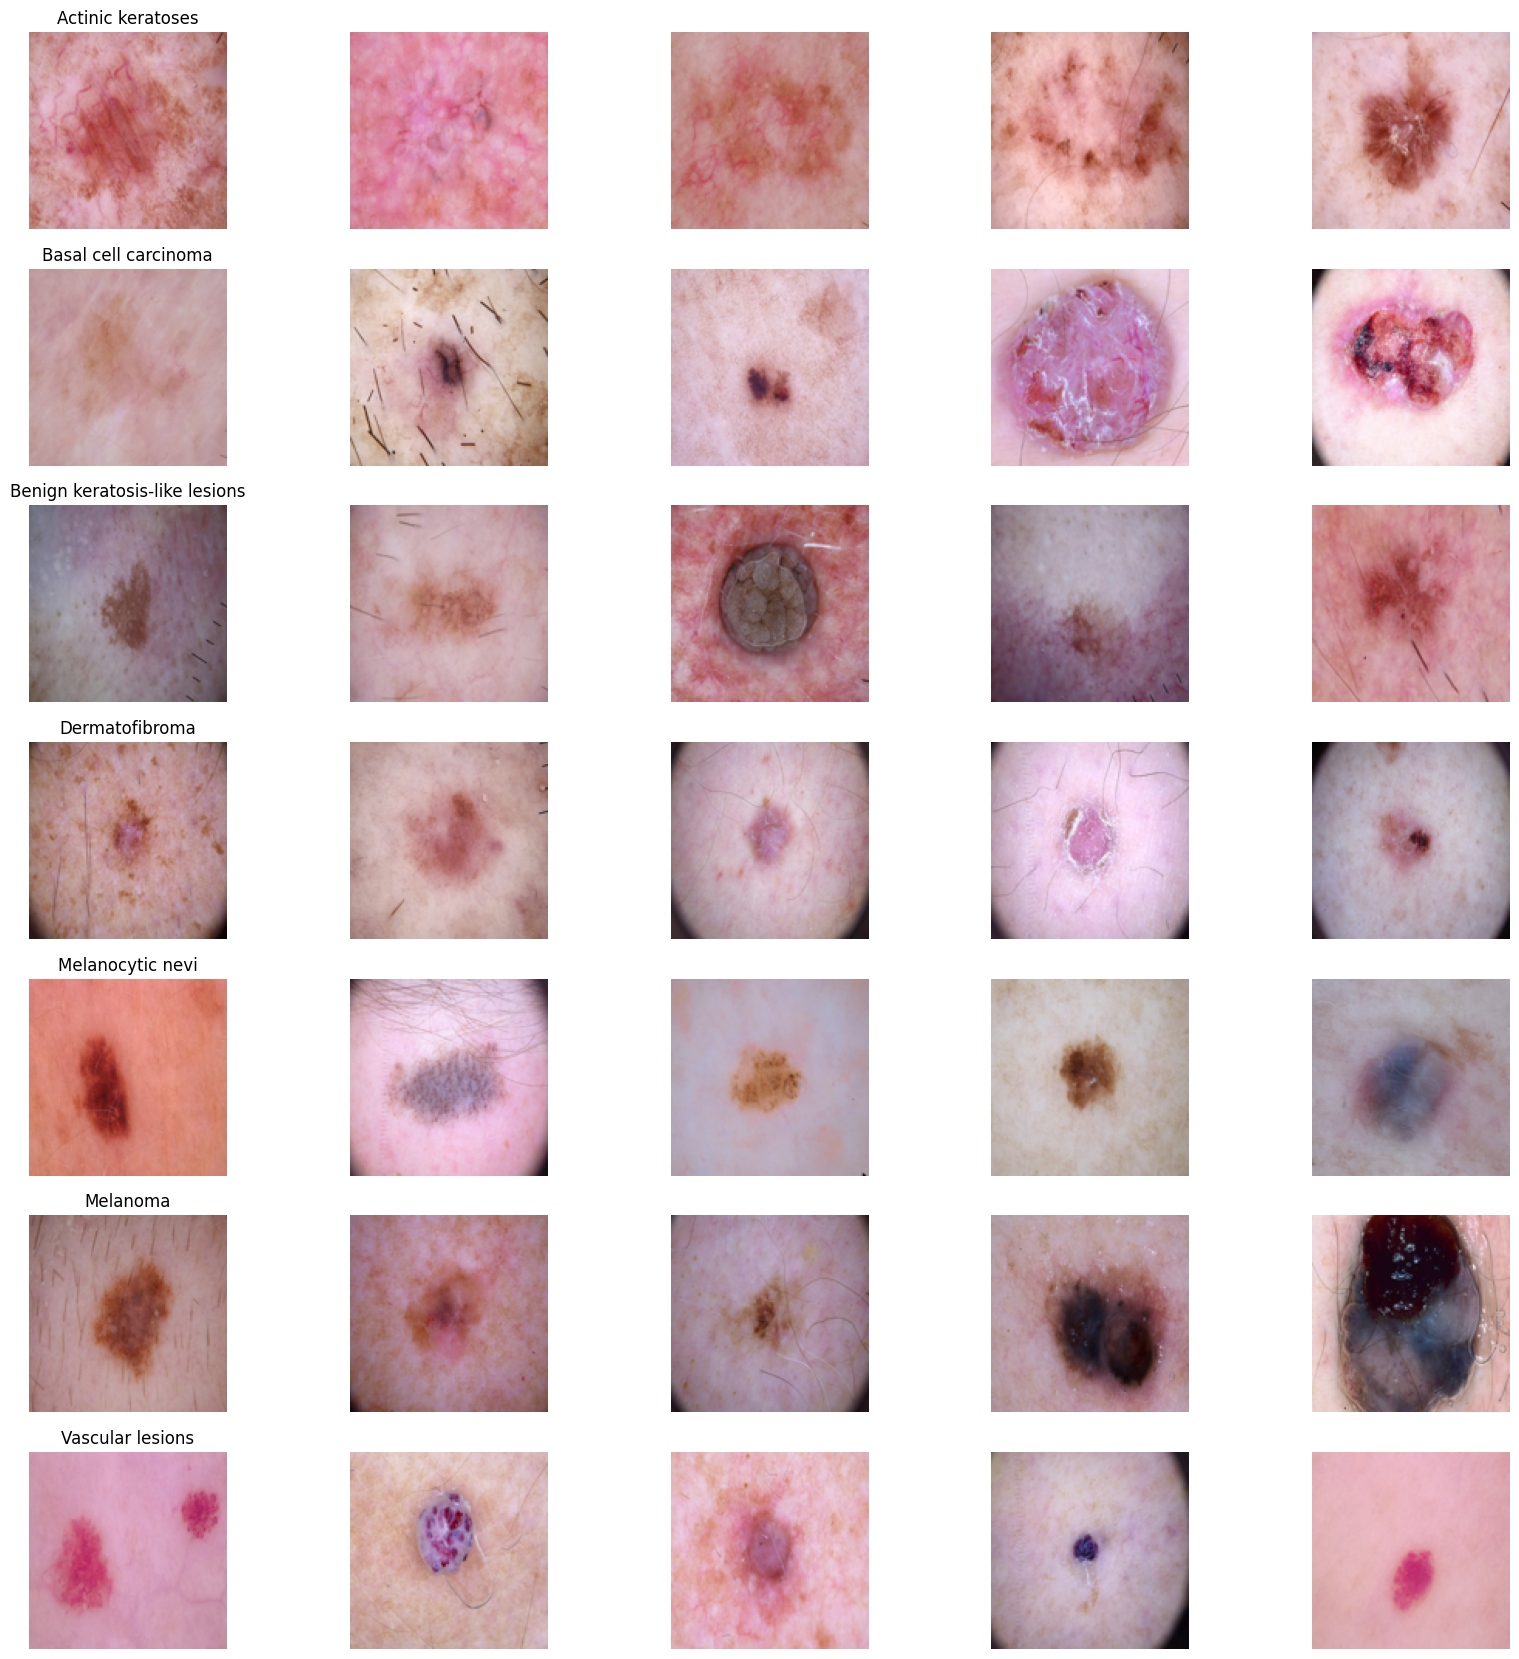

In [31]:
# Check the sample images
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [32]:
# Define the features and the labels as a prepration for the model training
features = df.drop(columns=['cell_type_idx'],axis=1)
labels = df['cell_type_idx']

In [33]:
# Split the DataFrame into training and testing sets (80:20)
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(features, labels, test_size=0.20,random_state=42)

# Output the sizes of the resulting DataFrames
print(f"Training set size: {len(x_train_df)}")
print(f"Testing set size: {len(x_test_df)}")

Training set size: 8012
Testing set size: 2003


In [34]:
# Convert integer labels to one-hot encoding
y_train = to_categorical(y_train_df, num_classes=7)
y_test = to_categorical(y_test_df, num_classes=7)

# Check the shapes of the resulting one-hot encoded arrays
print(f"One-hot encoded training labels shape: {y_train.shape}")
print(f"One-hot encoded testing labels shape: {y_test.shape}")

One-hot encoded training labels shape: (8012, 7)
One-hot encoded testing labels shape: (2003, 7)


In [35]:
# Extract images from the DataFrames
x_train = np.array([np.array(img) for img in x_train_df['image']])
x_test = np.array([np.array(img) for img in x_test_df['image']])

In [36]:
# Calculate mean and standard deviation for the training set
mean = x_train.mean(axis=(0, 1, 2), keepdims=True)
std = x_train.std(axis=(0, 1, 2), keepdims=True)

# Normalize the training and testing datasets
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Check the shape of the normalized data
print(f"x_train normalized shape: {x_train.shape}")
print(f"x_test normalized shape: {x_test.shape}")

x_train normalized shape: (8012, 128, 128, 3)
x_test normalized shape: (2003, 128, 128, 3)


In [37]:
# Split the training data into training and validation sets (90:10)
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train,             # Normalized training images
    y_train,             # One-hot encoded training labels
    test_size=0.1,       # 10% for validation
    random_state=2      # For reproducibility
)

# Output the sizes of the resulting sets
print(f"Final training set size: {x_train.shape[0]}")
print(f"Validation set size: {x_validate.shape[0]}")

Final training set size: 7210
Validation set size: 802


In [38]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(128, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(128, 128, 3))

In [39]:
# Initialize the model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 classes for skin cancer types

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,502,055 (9.54 MB)

 Trainable params: 2,501,415 (9.54 MB)

 Non-trainable params: 640 (2.50 KB)

In [40]:
from keras.optimizers import Adam

# Optimizer algorithm to speed up training
optimizer = Adam(learning_rate=0.001)

In [41]:
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for Dense Classification
    gamma: focusing parameter for modulating factor (1-p)
    alpha: balancing factor to adjust the weighting of positive/negative classes
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate cross-entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate modulating factor (1 - p_t)^gamma
        modulating_factor = K.pow(1. - y_pred, gamma)

        # Apply alpha and modulating factor to the cross-entropy
        loss = alpha * modulating_factor * cross_entropy

        # Reduce mean of the loss across the batch
        return K.mean(K.sum(loss, axis=-1))

    return focal_loss_fixed

In [42]:
model.compile(optimizer=optimizer,
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy'])

In [43]:
# Learning rate decay
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)

In [44]:
# Create an instance of ImageDataGenerator with desired augmentations
data_gen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    horizontal_flip=False,         # Randomly flip images horizontally
    vertical_flip=False,           # Randomly flip images vertically
    rotation_range=10,            # Rotate images in the range (0-10 degrees)
    width_shift_range=0.1,        # Randomly shift images horizontally (10% of width)
    height_shift_range=0.1,       # Randomly shift images vertically (10% of height)
    brightness_range=[0.9, 1.1],  # Adjust brightness randomly
    zoom_range=0.1,               # Randomly zoom in or out
    shear_range=0.1,              # Shear angle in counter-clockwise direction
)

data_gen.fit(x_train)

In [45]:
# Fit the model
epochs = 50
batch_size = 16
class_weight = {
    0: 10.0,
    1: 6.0,
    2: 3.0,
    3: 30.0,
    4: 0.5,
    5: 3.0,
    6: 30.0
}

# Creating a generator for the training data
train_generator = data_gen.flow(x_train, y_train, batch_size=batch_size)

history = model.fit(
    train_generator,
    epochs = epochs,
    callbacks=[reduce_lr],
    class_weight = class_weight,
    validation_data = (x_validate,y_validate),
    verbose = 1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 192s 413ms/step - accuracy: 0.5823 - loss: 1.6892 - val_accuracy: 0.6347 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 195s 431ms/step - accuracy: 0.6508 - loss: 0.5191 - val_accuracy: 0.6421 - val_loss: 0.1960 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 188s 416ms/step - accuracy: 0.6539 - loss: 0.5629 - val_accuracy: 0.6446 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 184s 408ms/step - accuracy: 0.6458 - loss: 0.5903 - val_accuracy: 0.6434 - val_loss: 0.2198 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 183s 405ms/step - accuracy: 0.6600 - loss: 0.4962 - val_accuracy: 0.6384 - val_loss: 0.1470 - learning_rate: 2.0000e-04
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 195s 431ms/step - accuracy: 0.6671 - loss: 0.4768 - val_accuracy: 0.6484 - val_loss: 0.1478 - learning_rate: 2.0000e-04
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 182s 402ms/step - accuracy:

In [46]:
model.save('/kaggle/working/skin_cancer_model.h5')


In [47]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
val_loss, val_accuracy = model.evaluate(x_validate, y_validate, verbose=1)

print(f"Validation: val_accuracy = {val_accuracy: .4f} ;  val_loss = {val_loss: .4f}")
print(f"Test: accuracy = {accuracy: .4f} ;  loss = {loss: .4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.7112 - loss: 0.1091
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.7153 - loss: 0.1074
Validation: val_accuracy =  0.7070 ;  val_loss =  0.1103
Test: accuracy =  0.7204 ;  loss =  0.1071


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step


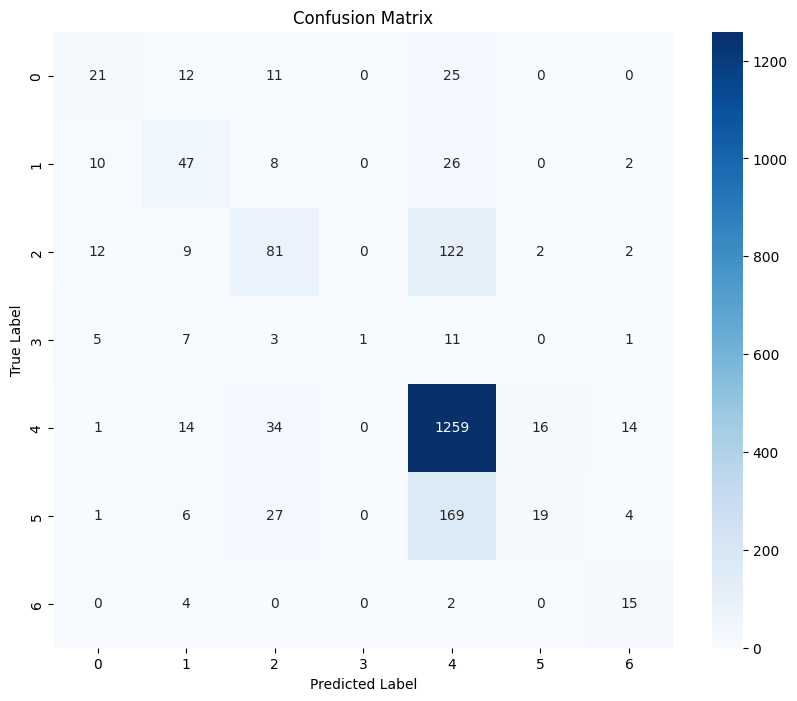

ROC AUC Score: 0.8923
Classification Report:
              precision    recall  f1-score   support

       akiec       0.42      0.30      0.35        69
         bcc       0.47      0.51      0.49        93
         bkl       0.49      0.36      0.41       228
          df       1.00      0.04      0.07        28
          nv       0.78      0.94      0.85      1338
         mel       0.51      0.08      0.14       226
        vasc       0.39      0.71      0.51        21

    accuracy                           0.72      2003
   macro avg       0.58      0.42      0.40      2003
weighted avg       0.69      0.72      0.67      2003



In [48]:
# Step 1: Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert true labels from one-hot to class labels

# Step 2: Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 4: Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc'])

# Compute the ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Output classification report
print("Classification Report:")
print(class_report)

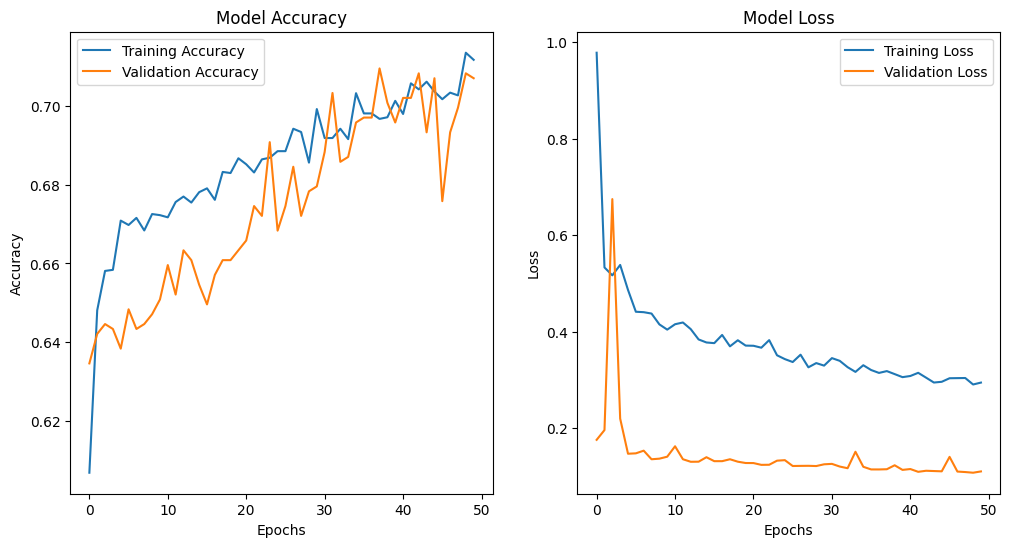

In [49]:
# Extract accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

# Show the plots
plt.show()

Text(0, 0.5, 'Fraction of Incorrect Prediction')

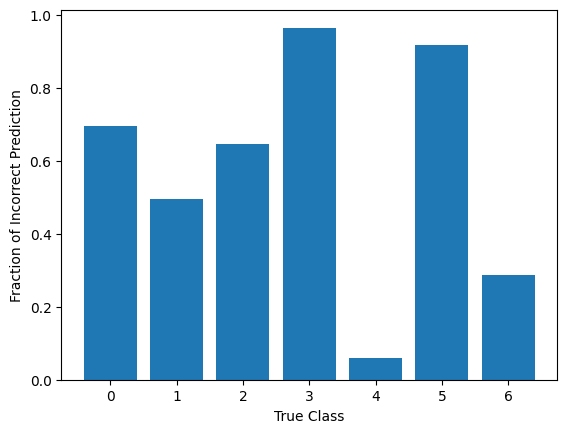

In [50]:
inc_misclass = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
plt.bar(np.arange(7), inc_misclass)
plt.xlabel("True Class")
plt.ylabel("Fraction of Incorrect Prediction")

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:35<00:00, 156MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [5]:
!pip install kaggle

จดบันทึก ขั้นที่ 1